# AdaBoost on German credit data

We apply AdaBoost to a credit data set. It'll turn out that we need to do a bit of preprocessing first.

In [1]:
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
plt.style.use("seaborn")

## German credit data set

We first load the data from the open data repository https://www.openml.org/home.

In [2]:
# fetch data from openml.org
# see https://www.openml.org/d/31
from sklearn.datasets import fetch_openml
data = fetch_openml('credit-g', cache=True)
print(data.DESCR)
X, y = data["data"], data["target"]


**Author**: Dr. Hans Hofmann  
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)) - 1994    
**Please cite**: [UCI](https://archive.ics.uci.edu/ml/citation_policy.html)

**German Credit dataset**  
This dataset classifies people described by a set of attributes as good or bad credit risks.

This dataset comes with a cost matrix: 
``` 
      Good  Bad (predicted)  
Good   0    1   (actual)  
Bad    5    0  
```

It is worse to class a customer as good when they are bad (5), than it is to class a customer as bad when they are good (1).  

### Attribute description  

1. Status of existing checking account, in Deutsche Mark.  
2. Duration in months  
3. Credit history (credits taken, paid back duly, delays, critical accounts)  
4. Purpose of the credit (car, television,...)  
5. Credit amount  
6. Status of savings account/bonds, in Deutsche Mark.  
7. Present employment, in number of years.  
8. Installment rate in percentage of disposable income  
9.

As we can see the credit data set classifies applicants into those with good or bad credit risk (whatever that means). It's an old data set as we can note by the fact that checking amount is in DM and that a noteworthy feature is whether a customer has a telephone or not. Note also feature #9, married/single and sex. It's quite doubtful whether it's legitimate to use that to estimate the credit worthiness. This is all the more true for feature #20, foreign worker yes/no, which seems blatant discrimination to me. 

In [3]:
print("shape of data set: {}".format(X.shape))
good=sum(y=='good')
bad=sum(y=='bad')
print("good v bad credit risk: {} v {}".format(good,bad))

shape of data set: (1000, 20)
good v bad credit risk: 700 v 300


It's always good to look at the size of the data set and at the class balance. Here we see that the majority has a good credit risk. 

We split the data in a training and a test set. Then we'll have a first look at the training set.

In [4]:
X, y = sklearn.utils.shuffle(X,y)
train_size=800
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

X_train.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
377,no checking,7.0,delayed previously,radio/tv,846.0,no known savings,>=7,3.0,male single,none,4.0,no known property,36.0,none,for free,1.0,skilled,1.0,none,yes
857,no checking,15.0,critical/other existing credit,furniture/equipment,3343.0,<100,1<=X<4,4.0,male single,none,2.0,no known property,28.0,none,for free,1.0,skilled,1.0,yes,yes
233,0<=X<200,18.0,existing paid,radio/tv,866.0,<100,1<=X<4,4.0,male mar/wid,guarantor,2.0,real estate,25.0,none,own,1.0,unskilled resident,1.0,none,yes
487,no checking,24.0,existing paid,new car,3757.0,<100,>=7,4.0,female div/dep/mar,co applicant,4.0,no known property,62.0,none,for free,1.0,skilled,1.0,yes,yes
500,<0,24.0,existing paid,new car,3123.0,<100,<1,4.0,female div/dep/mar,none,1.0,life insurance,27.0,none,own,1.0,skilled,1.0,none,yes


Hmmm, a good number of the features are categorical, ie, we have entries such as "male single" etc. We should investigate this in more detail. Let's first look at some random column and see what unique values we have there.

In [5]:
list(X_train["personal_status"].unique())

['male single', 'male mar/wid', 'female div/dep/mar', 'male div/sep']

Eh. Wow, this data set ist terrible. Why are there three categories for men but only one for women? And is "div/dep/mar" short for divorced, dependent or married? Women can be dependent but not men? Also no single women? Wonderful. Not only is this data set xenophobic but also sexist. 

Let's look at all the non-numerical data.

In [6]:
categorical_columns=["checking_status","credit_history","purpose","savings_status",
               "employment","personal_status","other_parties","property_magnitude",
               "other_payment_plans","housing","job","own_telephone","foreign_worker"]
for column in categorical_columns:
    print("** {} **".format(column))
    print(list(X_train[column].unique().categories))
    print()

** checking_status **
['no checking', '0<=X<200', '<0', '>=200']

** credit_history **
['delayed previously', 'critical/other existing credit', 'existing paid', 'no credits/all paid', 'all paid']

** purpose **
['radio/tv', 'furniture/equipment', 'new car', 'used car', 'business', 'repairs', 'education', 'retraining', 'other', 'domestic appliance']

** savings_status **
['no known savings', '<100', '>=1000', '500<=X<1000', '100<=X<500']

** employment **
['>=7', '1<=X<4', '<1', '4<=X<7', 'unemployed']

** personal_status **
['male single', 'male mar/wid', 'female div/dep/mar', 'male div/sep']

** other_parties **
['none', 'guarantor', 'co applicant']

** property_magnitude **
['no known property', 'real estate', 'life insurance', 'car']

** other_payment_plans **
['none', 'stores', 'bank']

** housing **
['for free', 'own', 'rent']

** job **
['skilled', 'unskilled resident', 'high qualif/self emp/mgmt', 'unemp/unskilled non res']

** own_telephone **
['none', 'yes']

** foreign_worker

Okay, we now have two tasks: 
1. drop the sexist/xenophobic features
2. encode categorical data as numerical data
We could do this directly in the data (in the <code>pandas.DataFrame</code>). It is cleaner, however, to define a transformer that can also handle new data. 

How do we encode values such as 'none', 'bank', 'stores'? There are two ways: we do one-hot encoding, or we encode this into ordinal values. The first option is usually better. It would turn a feature with three different unique values into a 0,1-vector of length 3; see [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder). Because AdaBoost is based on decision trees we can actually work with an ordinal encoding: values such as 'none', 'bank', 'stores' get mapped to numbers 0,1,2. [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder) provides a transformer that does exactly that. Let's try it out:

In [7]:
ord_encoder=sklearn.preprocessing.OrdinalEncoder()
ord_encoder.fit_transform(X_train[:3])

array([[1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 2., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 1., 0., 0., 2., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0.],
       [0., 2., 2., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
        1., 0., 0., 0.]])

One problem: <code>OrdinalEncoder</code> now treats *every* feature as a categorical feature. There are, however, numerical features such as *duration* that we want keep unchanged. 

To treat only certain columns we use a [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer.fit_transform). We actually use the convenience method<code>make_column_transformer</code> that takes a list of tuples (transformer, columns) and then applies the transformer only to those columns. We also set the argument <code>remainder="passthrough"</code> to keep the other (numerical) columns unchanged.

In [8]:
from sklearn.compose import make_column_transformer
ord_enc=sklearn.preprocessing.OrdinalEncoder()
column_transformer=make_column_transformer((ord_enc,categorical_columns),remainder="passthrough")
column_transformer.fit_transform(X_train)

array([[ 3.,  2.,  6., ..., 36.,  1.,  1.],
       [ 3.,  1.,  3., ..., 28.,  1.,  1.],
       [ 0.,  3.,  6., ..., 25.,  1.,  1.],
       ...,
       [ 0.,  1.,  6., ..., 23.,  2.,  1.],
       [ 1.,  1.,  7., ..., 65.,  2.,  1.],
       [ 2.,  3.,  2., ..., 23.,  1.,  1.]])

Only problem: we still have the xenophobic/sexist features that we do not want to use. If we look at <code>[make_column_transformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html#sklearn.compose.make_column_transformer)</code> we see that there is a way to drop certain columns by adding a tuple <code>('drop',columns_to_be_dropped)</code>.

In [9]:
categorical_columns=["checking_status","credit_history","purpose","savings_status",
               "employment","other_parties","property_magnitude",
               "other_payment_plans","housing","job","own_telephone"]
unethical_features=["personal_status","foreign_worker"]
ord_enc=sklearn.preprocessing.OrdinalEncoder()
column_transformer=make_column_transformer((ord_enc,categorical_columns),('drop',unethical_features),remainder="passthrough")
column_transformer.fit_transform(X_train)

array([[ 3.,  2.,  6., ..., 36.,  1.,  1.],
       [ 3.,  1.,  3., ..., 28.,  1.,  1.],
       [ 0.,  3.,  6., ..., 25.,  1.,  1.],
       ...,
       [ 0.,  1.,  6., ..., 23.,  2.,  1.],
       [ 1.,  1.,  7., ..., 65.,  2.,  1.],
       [ 2.,  3.,  2., ..., 23.,  1.,  1.]])

## run AdaBoost

We run AdaBoost once with many estimators and plot training and test error. 

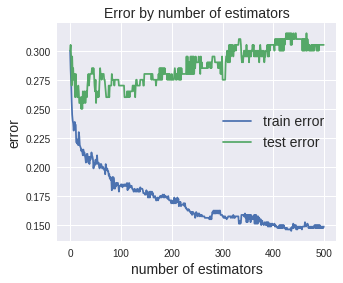

In [13]:
def ada_plot(train_errs,test_errs,filename=None):
    _,ax=plt.subplots(figsize=(5,4))
    ax.plot(range(len(train_errs)),train_errs,label="train error")
    ax.plot(range(len(test_errs)),test_errs,label="test error")
    ax.set_title("Error by number of estimators",fontsize=14)
    ax.set_ylabel("error",fontsize=14)
    ax.set_xlabel("number of estimators",fontsize=14)
    ax.legend(fontsize=14)
    if filename is not None:
        plt.savefig(filename,dpi=300)
    plt.show()    

categorical_columns=["checking_status","credit_history","purpose","savings_status",
               "employment","other_parties","property_magnitude",
               "other_payment_plans","housing","job","own_telephone"]
unethical_features=["personal_status","foreign_worker"]
ord_enc=sklearn.preprocessing.OrdinalEncoder()
column_transformer=make_column_transformer((ord_enc,categorical_columns),('drop',unethical_features),remainder="passthrough")

ada=AdaBoostClassifier(n_estimators=500)

ada.fit(column_transformer.fit_transform(X_train),y_train)
train_errs_by_round=[zero_one_loss(y_train,pred) for pred in ada.staged_predict(column_transformer.transform(X_train))]
test_errs_by_round=[zero_one_loss(y_test,pred) for pred in ada.staged_predict(column_transformer.transform(X_test))]
ada_plot(train_errs_by_round,test_errs_by_round)

## repeat several times

Let's repeat that several times to get a more stable picture of what's happening here. We train 50 instances of AdaBoost, each with 200 estimators. We then plot the means.

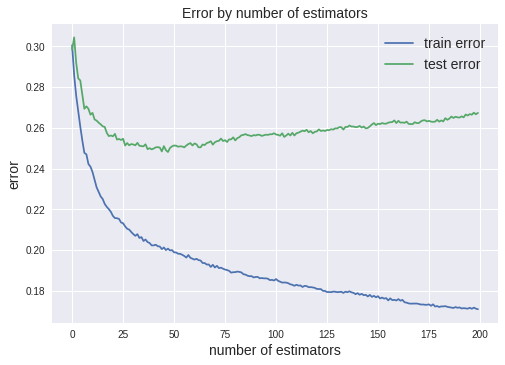

In [11]:
repeats=50
ada=AdaBoostClassifier(n_estimators=200)
train_errs_by_round=[]
test_errs_by_round=[]
for r in range(repeats):
    X, y = sklearn.utils.shuffle(X,y)
    X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]
    ada.fit(column_transformer.fit_transform(X_train),y_train)
    train_errs_by_round.append([zero_one_loss(y_train,pred) for pred in ada.staged_predict(column_transformer.transform(X_train))])
    test_errs_by_round.append([zero_one_loss(y_test,pred) for pred in ada.staged_predict(column_transformer.transform(X_test))])
train_errs=np.array(train_errs_by_round).mean(axis=0)
test_errs=np.array(test_errs_by_round).mean(axis=0)

ada_plot(train_errs,test_errs,filename="adagerman.png")

Let's also try a more powerful base estimator. The default base estimator is a decision stump -- now let's try with a decision tree of depth 2.

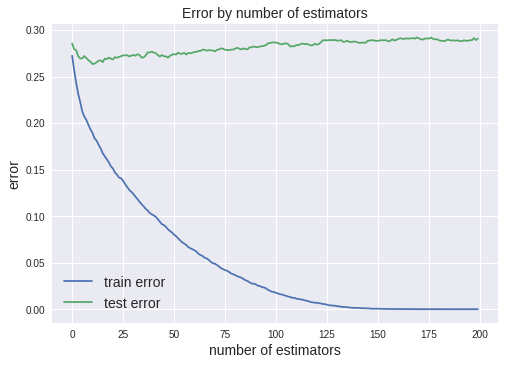

In [12]:
repeats=50
ada=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),n_estimators=200)
train_errs_by_round=[]
test_errs_by_round=[]
for r in range(repeats):
    X, y = sklearn.utils.shuffle(X,y)
    X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]
    ada.fit(column_transformer.fit_transform(X_train),y_train)
    train_errs_by_round.append([zero_one_loss(y_train,pred) for pred in ada.staged_predict(column_transformer.transform(X_train))])
    test_errs_by_round.append([zero_one_loss(y_test,pred) for pred in ada.staged_predict(column_transformer.transform(X_test))])
train_errsX=np.array(train_errs_by_round).mean(axis=0)
test_errsX=np.array(test_errs_by_round).mean(axis=0)

ada_plot(train_errsX,test_errsX)

Training error drops much more quickly and actually to 0, as is expected. Test error is not better, though.